Initial ideas:
- feature joining last transaction data with current one (time of purchase, location)
- additional info based on the location of the transaction - if previous purchase was made in Portugal 2h ago, is it possible that the current one is made in Poland? probably not

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [2]:
df_transactions = pd.read_json('../data/transactions.json', lines=True)
df_users = pd.read_csv('../data/users.csv')
df_merchants = pd.read_csv('../data/merchants.csv')

In [3]:
df_transactions.head(1)

,transaction_id,timestamp,user_id,merchant_id,amount,channel,currency,device,location,payment_method,is_international,session_length_seconds,is_first_time_merchant,is_fraud
0,TX000000,2022-06-17 23:28:00,U14804,M0314,130.03,in-store,EUR,Android,"{'lat': 40.057938, 'long': 14.959737}",debit_card,1,145,0,0


In [4]:
df_merchants.head(1)

,merchant_id,category,country,trust_score,number_of_alerts_last_6_months,avg_transaction_amount,account_age_months,has_fraud_history
0,M0001,travel,Austria,1.0,3,97.23,84,0


In [5]:
df_users.head(1)

,user_id,age,sex,education,primary_source_of_income,sum_of_monthly_installments,sum_of_monthly_expenses,country,signup_date,risk_score
0,U00001,56,Other,High School,Employment,477.69,243.18,Finland,2021-04-01,0.571079


# Feature engineering

### 🕒 Temporal Features

| Feature Name                                | Format             | Use-Case                                                                 |
|--------------------------------------------|--------------------|--------------------------------------------------------------------------|
| hour of day                                 | Integer (0–23)     | Captures time-of-day behavior; useful for detecting night-time fraud     |
| day of week                                 | Integer (0–6)      | Weekly behavioral patterns; certain days may have higher fraud rates     |
| is weekend                                  | Boolean            | Distinguishes weekend activity; weekends often have different behavior   |
| month of transaction                        | Integer (1–12)     | Seasonal trends; useful for detecting periodic fraud campaigns           |
| time since last transaction - user-level    | Float (seconds)    | Captures user activity frequency; useful for behavioral profiling        |
| time since last transaction - merchant-level| Float (seconds)    | Captures merchant popularity; good for modeling merchant-specific fraud  |
| time since last user-merchant interaction   | Float (seconds)    | Detects anomalies in specific user-merchant interaction patterns         |

---

### 📊 Spatial Features
| Feature Name                               | Format             | Use-Case                                                                 |
|--------------------------------------------|--------------------|--------------------------------------------------------------------------|
| latitude and longitude extracted from dict | Float     | further feature engineering         |
| distance from last user transaction | Float (km)     |          |
| avg velocity between user transactions | Float (km/h)     | its not usually possible to travel 5000 km in 1 hour |


### 📊 Merchant-based Features
| Feature Name                               | Format             | Use-Case                                                                 |
|--------------------------------------------|--------------------|--------------------------------------------------------------------------|
|merchant fraud rate| Float (0-1)     | users have risk score which provides no predictive power, but merchant risk score turns out to be a good predictor of fraud |

In [6]:
# --------- Temporal data feature engineering

df_transactions['hour'] = df_transactions['timestamp'].dt.hour
df_transactions['day_of_week'] = df_transactions['timestamp'].dt.dayofweek  # 0=Monday
df_transactions['is_weekend'] = df_transactions['day_of_week'] >= 5
df_transactions['month'] = df_transactions['timestamp'].dt.month

# Time Since Last Transaction: User-level
df_transactions = df_transactions.sort_values(['user_id', 'timestamp'])
df_transactions['time_since_last_user_txn'] = (
    df_transactions.groupby('user_id')['timestamp']
    .diff()
    .dt.total_seconds()
)

# Time Since Last Transaction: Merchant-level
df_transactions = df_transactions.sort_values(['merchant_id', 'timestamp'])
df_transactions['time_since_last_merchant_txn'] = (
    df_transactions.groupby('merchant_id')['timestamp']
    .diff()
    .dt.total_seconds()
)

df_transactions['last_user_merchant_ts'] = df_transactions.groupby(['user_id', 'merchant_id'])['timestamp'].shift(1)
df_transactions['time_since_last_user_merchant'] = (df_transactions['timestamp'] - df_transactions['last_user_merchant_ts']).dt.total_seconds()

df_transactions.drop(columns=['last_user_merchant_ts'], inplace=True)

#TODO: time since last transaction: user-merchant level

### Spatial feature engineering

In [7]:
from math import radians, sin, cos, sqrt, atan2
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c  # distance in km

In [8]:
# --------- Geo-data feature engineering
# Extract latitude and longitude into separate columns
df_transactions['latitude'] = df_transactions['location'].apply(lambda x: x['lat'])
df_transactions['longitude'] = df_transactions['location'].apply(lambda x: x['long'])
df_transactions.drop(columns=['location'], inplace=True)

df_transactions.sort_values(by=['user_id', 'timestamp'], inplace=True)

# Shift lat/lon to get last user's lat/lon
df_transactions['prev_latitude'] = df_transactions.groupby('user_id')['latitude'].shift(1)
df_transactions['prev_longitude'] = df_transactions.groupby('user_id')['longitude'].shift(1)

df_transactions['distance_from_last_txn_km'] = df_transactions.apply(
    lambda row: haversine_distance(row['prev_latitude'], row['prev_longitude'],
                                   row['latitude'], row['longitude']),
    axis=1
)

df_transactions['velocity_kmph'] = df_transactions.apply(
    lambda row: (
        row['distance_from_last_txn_km'] / (row['time_since_last_user_txn'] / 3600)
        if row['time_since_last_user_txn'] > 0 else np.nan
    ),
    axis=1
)

df_transactions.head()

,transaction_id,timestamp,user_id,merchant_id,amount,channel,currency,device,payment_method,is_international,...,month,time_since_last_user_txn,time_since_last_merchant_txn,time_since_last_user_merchant,latitude,longitude,prev_latitude,prev_longitude,distance_from_last_txn_km,velocity_kmph
290822,TX290822,2022-01-08 10:03:00,U00001,M0906,19.09,online,EUR,Web,debit_card,1,...,1,NaN,204900.0,NaN,69.291741,-7.726250,NaN,NaN,NaN,NaN
197951,TX197951,2022-01-08 16:48:00,U00001,M0245,32.24,online,EUR,Android,mobile_payment,1,...,1,24300.0,1140.0,NaN,54.710715,15.368695,69.291741,-7.726250,1993.988051,295.405637
187979,TX187979,2022-01-12 16:23:00,U00001,M0332,4.29,in-store,EUR,Android,debit_card,1,...,1,344100.0,71940.0,NaN,58.897717,30.255430,54.710715,15.368695,1015.860215,10.628006
137034,TX137034,2022-01-18 10:40:00,U00001,M0331,67.00,in-store,EUR,iOS,debit_card,1,...,1,497820.0,81780.0,NaN,42.684202,3.843828,58.897717,30.255430,2556.056611,18.484199
401318,TX401318,2022-07-18 08:05:00,U00001,M0971,3.59,in-store,EUR,Web,mobile_payment,1,...,7,15629100.0,76920.0,NaN,44.296089,15.749937,42.684202,3.843828,976.137696,0.224843


In [9]:
# --------- Merchant data feature engineering
merchant_fraud_rates = df_transactions.groupby('merchant_id')['is_fraud'].mean()
df_transactions = df_transactions.merge(merchant_fraud_rates.rename('merchant_fraud_rate'), on='merchant_id')

In [10]:
df_users.rename(columns = lambda x: x + '_user' if x != 'user_id' else x, inplace=True)
df_merchants.rename(columns = lambda x: x + '_merchant' if x != 'merchant_id' else x, inplace=True)

df_merged = df_transactions.merge(df_users, on='user_id', how='left')
df_merged = df_merged.merge(df_merchants, on='merchant_id', how='left')
df_merged.head()

,transaction_id,timestamp,user_id,merchant_id,amount,channel,currency,device,payment_method,is_international,...,country_user,signup_date_user,risk_score_user,category_merchant,country_merchant,trust_score_merchant,number_of_alerts_last_6_months_merchant,avg_transaction_amount_merchant,account_age_months_merchant,has_fraud_history_merchant
0,TX290822,2022-01-08 10:03:00,U00001,M0906,19.09,online,EUR,Web,debit_card,1,...,Finland,2021-04-01,0.571079,grocery,Belgium,0.631421,2,26.85,37,0
1,TX197951,2022-01-08 16:48:00,U00001,M0245,32.24,online,EUR,Android,mobile_payment,1,...,Finland,2021-04-01,0.571079,gaming,Spain,0.859810,2,197.43,115,1
2,TX187979,2022-01-12 16:23:00,U00001,M0332,4.29,in-store,EUR,Android,debit_card,1,...,Finland,2021-04-01,0.571079,grocery,Spain,0.934815,5,18.36,68,0
3,TX137034,2022-01-18 10:40:00,U00001,M0331,67.00,in-store,EUR,iOS,debit_card,1,...,Finland,2021-04-01,0.571079,gaming,Belgium,0.859404,6,123.91,94,1
4,TX401318,2022-07-18 08:05:00,U00001,M0971,3.59,in-store,EUR,Web,mobile_payment,1,...,Finland,2021-04-01,0.571079,clothing,Germany,0.516453,1,0.98,52,1


<Axes: >

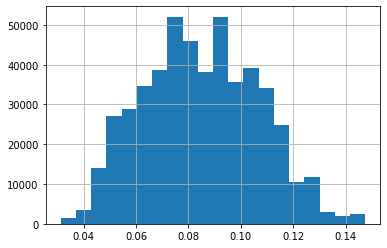

In [11]:
df_merged['merchant_fraud_rate'].hist(bins = 20)

In [28]:
parameters = {
    "window" : '1h',
    "zscore_threshold" : 3
}

In [29]:
df_merged['timestamp'] = pd.to_datetime(df_merged['timestamp'])
df_merged = df_merged.sort_values(by=['country_merchant', 'timestamp'])
df_merged.set_index('timestamp', inplace=True)

# 8-hour rolling stats

df_merged['rolling_fraud_count'] = (
    df_merged
    .groupby('country_merchant')['is_fraud']
    .rolling(window=parameters['window'])
    .sum()
    .reset_index(level=0, drop=True)
)

df_merged['rolling_txn_count'] = (
    df_merged
    .groupby('country_merchant')['is_fraud']
    .rolling(window=parameters['window'])
    .count()
    .reset_index(level=0, drop=True)
)

df_merged['rolling_fraud_rate'] = (
    df_merged['rolling_fraud_count'] / df_merged['rolling_txn_count']
).fillna(0)

df_merged = df_merged.reset_index()

In [30]:
top_countries = (
    df_merged[df_merged['is_fraud'] == 1]
    .groupby('country_merchant')
    .size()
    .sort_values(ascending=False)
    .head(5)  # adjust as needed
    .index
)

# Create subplots
fig, axes = plt.subplots(nrows=len(top_countries), ncols=1, figsize=(12, 4 * len(top_countries)), sharex=True)

# Ensure axes is iterable
if len(top_countries) == 1:
    axes = [axes]

# Plot each country
for ax, country in zip(axes, top_countries):
    subset = df_merged[df_merged['country_merchant'] == country]
    ax.plot(subset['timestamp'], subset['rolling_fraud_rate'], label=country, color='teal')
    ax.set_title(f'{parameters['window']} Rolling Fraud Rate - {country}')
    ax.set_ylabel("Fraud Rate")
    ax.grid(True)
    ax.legend()

plt.xlabel("Time")
plt.tight_layout()
plt.show()

SyntaxError: f-string: unmatched '[' (1351026401.py, line 21)

In [31]:
df_merged['fraud_rate_change'] = (
    df_merged.groupby('country_merchant')['rolling_fraud_rate'].diff()
)

# Z-score of fraud rate per country_merchant
df_merged['zscore_fraud_rate'] = (
    df_merged.groupby('country_merchant')['rolling_fraud_rate']
    .transform(lambda x: zscore(x.fillna(0)))
)

# Attack starts: rate jumps or statistical spike
df_merged['fraud_attack_start_flag'] = (
    # (df_merged['fraud_rate_change'] > 0.15) |
    (df_merged['zscore_fraud_rate'] > parameters['zscore_threshold'])
)

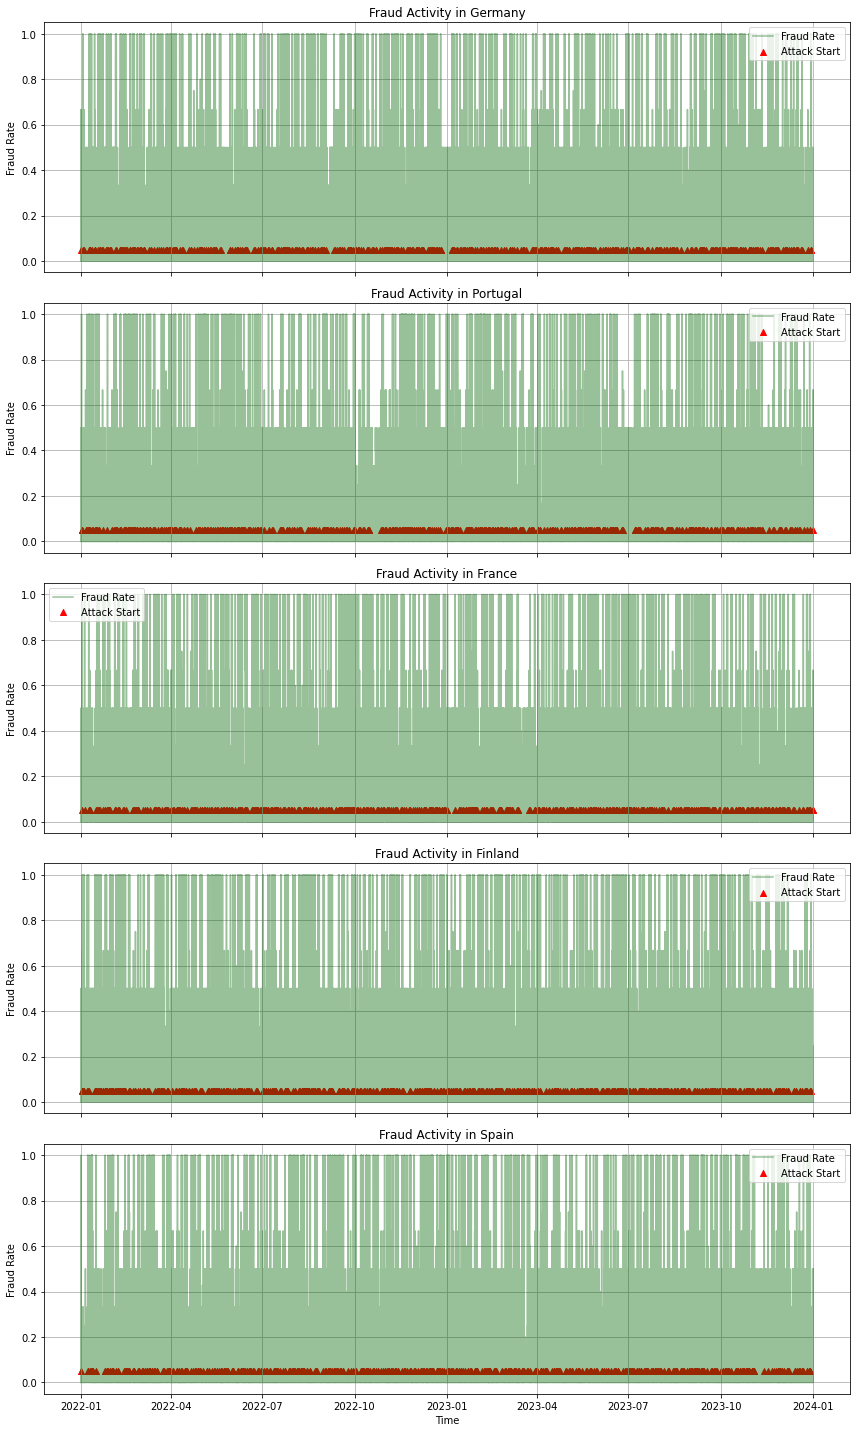

In [32]:
top_countries = (
    df_merged[df_merged['is_fraud'] == 1]
    .groupby('country_merchant')
    .size()
    .sort_values(ascending=False)
    .head(5)
    .index
)

fig, axes = plt.subplots(nrows=len(top_countries), ncols=1, figsize=(12, 4 * len(top_countries)), sharex=True)

for ax, country in zip(axes, top_countries):
    subset = df_merged[df_merged['country_merchant'] == country]
    ax.plot(subset['timestamp'], subset['rolling_fraud_rate'], label='Fraud Rate', color='darkgreen', alpha = 0.4)
    
    # Attack start markers
    attack_start_times = subset[subset['fraud_attack_start_flag']]['timestamp']
    ax.scatter(attack_start_times, [0.05]*len(attack_start_times), color='red', marker='^', label='Attack Start')

    ax.set_title(f"Fraud Activity in {country}")
    ax.set_ylabel("Fraud Rate")
    ax.legend()
    ax.grid(True)

plt.xlabel("Time")
plt.tight_layout()
plt.show()

In [33]:
# Define attack stop: rate returns to normal
df_merged['fraud_attack_stop_flag'] = (
    (df_merged['zscore_fraud_rate'] < 1.0) &
    (df_merged['fraud_rate_change'] < 0)
)

# Initialize attack window status
df_merged['in_attack'] = False

# Apply per-country attack window labelling
for country in df_merged['country_merchant'].unique():
    mask = df_merged['country_merchant'] == country
    df_country = df_merged.loc[mask].copy()

    # Boolean series to hold attack periods
    attack_flags = []
    in_attack = False

    for i in range(len(df_country)):
        if df_country.iloc[i]['fraud_attack_start_flag']:
            in_attack = True
        elif df_country.iloc[i]['fraud_attack_stop_flag']:
            in_attack = False
        attack_flags.append(in_attack)

    df_merged.loc[mask, 'in_attack'] = attack_flags

In [34]:
# Total frauds
total_frauds = df_merged['is_fraud'].sum()

# Frauds during detected attacks
frauds_during_attack = df_merged[df_merged['in_attack'] & (df_merged['is_fraud'] == 1)].shape[0]

# Percent
percent_detected = (frauds_during_attack / total_frauds) * 100

print(f"🔍 {percent_detected:.2f}% of fraudulent transactions occurred during detected attack periods.")


🔍 21.02% of fraudulent transactions occurred during detected attack periods.


In [35]:
# Transactions inside attack
txns_in_attack = df_merged[df_merged['in_attack']].shape[0]

# Precision = how many of those were fraud
attack_precision = (frauds_during_attack / txns_in_attack) * 100

print(f"🎯 Attack interval precision: {attack_precision:.2f}% fraud rate during flagged periods.")

🎯 Attack interval precision: 43.14% fraud rate during flagged periods.


In [36]:
import numpy as np
from scipy.stats import zscore

def evaluate_attack_detection(df, parameters):
    df_eval = df.copy()
    
    # Prepare data
    df_eval['timestamp'] = pd.to_datetime(df_eval['timestamp'])
    df_eval = df_eval.sort_values(by=['country_merchant', 'timestamp'])
    df_eval.set_index('timestamp', inplace=True)
    
    window = parameters['window']  # e.g. '8h'
    z_thresh = parameters['zscore_threshold']  # e.g. 3.0
    
    # Rolling fraud stats
    df_eval['rolling_fraud_count'] = (
        df_eval.groupby('country_merchant')['is_fraud']
        .rolling(window=window).sum().reset_index(level=0, drop=True)
    )
    
    df_eval['rolling_txn_count'] = (
        df_eval.groupby('country_merchant')['is_fraud']
        .rolling(window=window).count().reset_index(level=0, drop=True)
    )
    
    df_eval['rolling_fraud_rate'] = (
        df_eval['rolling_fraud_count'] / df_eval['rolling_txn_count']
    ).fillna(0)
    
    # z-score + rate change
    df_eval['fraud_rate_change'] = (
        df_eval.groupby('country_merchant')['rolling_fraud_rate'].diff()
    )
    
    df_eval['zscore_fraud_rate'] = (
        df_eval.groupby('country_merchant')['rolling_fraud_rate']
        .transform(lambda x: zscore(x.fillna(0)))
    )
    
    # Start and stop flags
    df_eval['fraud_attack_start_flag'] = (
        (df_eval['zscore_fraud_rate'] > z_thresh) &
        (df_eval['fraud_rate_change'] > 0)
    )

    df_eval['fraud_attack_stop_flag'] = (
        (df_eval['zscore_fraud_rate'] < 1.0) &
        (df_eval['fraud_rate_change'] < 0)
    )

    # Label in_attack periods
    df_eval['in_attack'] = False
    for country in df_eval['country_merchant'].unique():
        mask = df_eval['country_merchant'] == country
        df_c = df_eval.loc[mask]
        in_attack = False
        flags = []

        for _, row in df_c.iterrows():
            if row['fraud_attack_start_flag']:
                in_attack = True
            elif row['fraud_attack_stop_flag']:
                in_attack = False
            flags.append(in_attack)
        
        df_eval.loc[mask, 'in_attack'] = flags
    
    # Stats
    total_fraud = df_eval['is_fraud'].sum()
    fraud_in_attack = df_eval[df_eval['in_attack'] & (df_eval['is_fraud'] == 1)].shape[0]
    total_in_attack = df_eval[df_eval['in_attack']].shape[0]

    coverage = 100 * fraud_in_attack / total_fraud if total_fraud else 0
    precision = 100 * fraud_in_attack / total_in_attack if total_in_attack else 0

    return {
        'parameters': parameters,
        'coverage_percent': coverage,
        'precision_percent': precision,
        'frauds_detected': fraud_in_attack,
        'attack_txns': total_in_attack
    }

In [38]:
windows = ['5min', '15min', '30min', '1h', '2h', '4h']
thresholds = [2.0, 2.5, 3.0, 3.5]

results = []

for w in windows:
    for z in thresholds:
        params = {'window': w, 'zscore_threshold': z}
        res = evaluate_attack_detection(df_merged, params)
        results.append(res)
        print('checked:', params)

df_results = pd.DataFrame(results)
df_results.sort_values(by='coverage_percent', ascending=False)

checked: {'window': '5min', 'zscore_threshold': 2.0}
checked: {'window': '5min', 'zscore_threshold': 2.5}
checked: {'window': '5min', 'zscore_threshold': 3.0}
checked: {'window': '5min', 'zscore_threshold': 3.5}
checked: {'window': '15min', 'zscore_threshold': 2.0}
checked: {'window': '15min', 'zscore_threshold': 2.5}
checked: {'window': '15min', 'zscore_threshold': 3.0}
checked: {'window': '15min', 'zscore_threshold': 3.5}
checked: {'window': '30min', 'zscore_threshold': 2.0}
checked: {'window': '30min', 'zscore_threshold': 2.5}
checked: {'window': '30min', 'zscore_threshold': 3.0}
checked: {'window': '30min', 'zscore_threshold': 3.5}
checked: {'window': '1h', 'zscore_threshold': 2.0}
checked: {'window': '1h', 'zscore_threshold': 2.5}
checked: {'window': '1h', 'zscore_threshold': 3.0}
checked: {'window': '1h', 'zscore_threshold': 3.5}
checked: {'window': '2h', 'zscore_threshold': 2.0}
checked: {'window': '2h', 'zscore_threshold': 2.5}
checked: {'window': '2h', 'zscore_threshold': 3.0}

,parameters,coverage_percent,precision_percent,frauds_detected,attack_txns
0,"{'window': '5min', 'zscore_threshold': 2.0}",86.812384,88.466529,36818,41618
2,"{'window': '5min', 'zscore_threshold': 3.0}",86.732216,88.469864,36784,41578
1,"{'window': '5min', 'zscore_threshold': 2.5}",86.732216,88.469864,36784,41578
4,"{'window': '15min', 'zscore_threshold': 2.0}",64.502134,70.969750,27356,38546
5,"{'window': '15min', 'zscore_threshold': 2.5}",63.787697,70.958689,27053,38125
6,"{'window': '15min', 'zscore_threshold': 3.0}",63.759402,70.955130,27041,38110
7,"{'window': '15min', 'zscore_threshold': 3.5}",60.000943,70.492257,25447,36099
12,"{'window': '1h', 'zscore_threshold': 2.0}",47.320271,42.497459,20069,47224
8,"{'window': '30min', 'zscore_threshold': 2.0}",43.427413,55.537798,18418,33163
9,"{'window': '30min', 'zscore_threshold': 2.5}",43.337813,55.528701,18380,33100
